In [1]:
import numpy as np

In [34]:
# This is the VisserVanGils2014 function IzhPopulation01.m translated into python.
# Alterations: added parameter w according to eq for I_syn under eq (11b) in the paper

def T(sqrtJj, g):
    return (10/sqrtJj)*np.arctan(((2*g)+125)/(5*sqrtJj))
    
    
def nfun(x, J, n0, n1, n2):
    return n2*x*x+n1*x+n0+J
    
    
def dX(t, X, P):
    V = X[0]
    u = X[1]
    S = X[2]
    
    n0 = P['n0'] # 
    n1 = P['n1'] # 
    n2 = P['n2'] # 
    a = P['a'] # decay rate of u
    b = P['b'] # slope parameter of u nullcline
    c = P['c'] # reset value after spike
    d = P['d'] # increment of u after spike in original model
    tauSyn = P['tauSyn'] # 1/alpha in paper, see def of Q above eq (12) in paper and eq (11c)
    g = P['g'] # maximal conductance
    w = P['w'] # expected self connection weight
    ESyn = P['ESyn']
    v_th = P["v_th"]
    Iext = P['Iext']
    
    fmin = P['fmin'] # this is cell specific!
    kappa = P['kappa']
    omega = P['omega']
    ckappa = P['ckappa']
    dnck = P['dnck']
    
    f=fmin
    
    I = Iext - S*w*g*(V - ESyn) # ISyn is double!!!! set to 0 for now
    J = I - u
    this_nfun = lambda x: nfun(x, J, n0, n1, n2)
    nc = this_nfun(c)
    # calculation of f_b:
    if nc > 0:
        if np.abs(4*J-65) < 0.1:
            J -= 0.1
        sqrtJj = np.real(np.sqrt((4*(J + 0j))-65))
        
        this_T = lambda x: T(sqrtJj, x)
        
        # the 30 here is v_thresh! -> maybe check nullclines for v_th != 30
        if (np.abs(this_T(v_th) - this_T(c)) < 0.01):
            f = fmin
        else:
            f = 1/(this_T(v_th) - this_T(c))
        f = max(f, fmin);
    
    H = 1.0 / (1.0 + np.exp(-omega*(V-(c)))) #smooth approximation of Heaviside function
    f = f*H
    
    #Determine coefficients for new branch xi*exp(eta*V)
    nck = this_nfun(ckappa)
    ncknc = nck-nc
    eta = dnck/ncknc               # eta in paper
    xi = ncknc/np.exp(eta*kappa)   # xi in paper
    
    dV = this_nfun(V) - xi*np.exp(eta*(V-c)) + P["nsig"]*np.random.normal()
    du = a*(b*V-u) + f*d
    dS = f - S / tauSyn
    
    return np.array([dV, du, dS])


In [35]:
X = np.array([-65,-12, 0]) # V, U, S
# Parameters: I took the mean values given under figure 4
# cave: I0 = 6 (external current)
#P = {'a': 0.02, 'b': 0.2, 'c': -55, 'd': 2, 'I0': 6, 'tauSyn': 10, 'g': 0.002, 'w': 0.03, 'ESyn': 0}
P = {'n0': 140.0, 'n1': 5.0, 'n2': 0.04, "fmin": 0.2, "kappa": 0.8, "omega": 20.0,  
     'a': 0.02, 'b': 0.2, 'c': -72.0, 'd': 2.0, 
     'Iext': 3.8, # 'Iext': 3.77, w = 0.1, for single noisy spikes
     'tauSyn': 10, 'g': 0.002, 'w': 0.1, 'ESyn': 0, "v_th": 30.0, "nsig": 0.0, 
     }
P["ckappa"] = P["c"] + P["kappa"]
P["dnck"] = 2 * P["n2"]*P["ckappa"] + P["n1"]


In [36]:
dX(1,X,P)

/home/docker/env/neurosci/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


array([9.61538782e+02, 3.80000000e-01, 2.00000000e-01])

In [37]:
# plot nullclines somehow

# import necessary libraries
import matplotlib.pyplot as plt
# show plots in notebook
#% matplotlib inline

# define system in terms of separated differential equations
def f(x,y):
    return 2*x - x**2 - x*y
def g(x,y):
    return - y + x*y

# initialize lists containing values
V = []
U = []
S = []
t = [0.0]

#iv1, iv2 = initial values, dt = timestep, time = range
def sys(iv1, iv2, iv3, dt, time):
    # initial values:
    V.append(iv1)
    U.append(iv2)
    S.append(iv3)
    # compute and fill lists
    for i in range(time):
        states = [V[i], U[i], S[i]]
        dstates = dX(i, states, P)
        V.append(V[i] + dstates[0] * dt)
        U.append(U[i] + dstates[1] * dt)
        S.append(S[i] + dstates[2] * dt)
        t.append(t[-1] + dt)
    return V, U, S, t

sys(-65, -12, 0.0, 0.1, 10000);


/home/docker/env/neurosci/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """
/home/docker/env/neurosci/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in double_scalars
/home/docker/env/neurosci/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in double_scalars


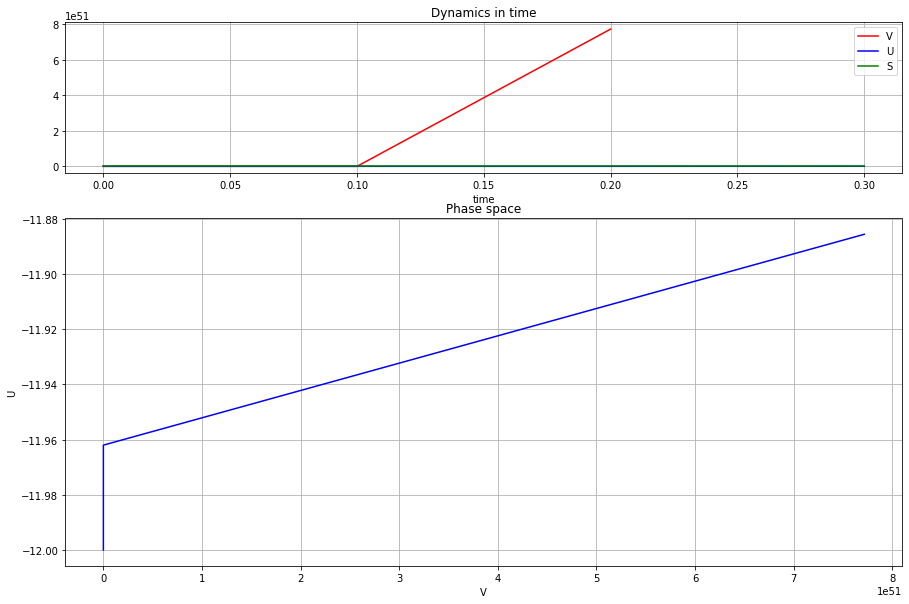

In [38]:
#plot
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(wspace = 0.5, hspace = 0.3)
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,(2, 3))

ax1.plot(t, V, 'r-', label='V')
ax1.plot(t, U, 'b-', label='U')
ax1.plot(t, S, 'g-', label='S')
ax1.set_title("Dynamics in time")
ax1.set_xlabel("time")
ax1.grid()
ax1.legend(loc='best')

ax2.plot(V, U, color="blue")
ax2.set_xlabel("V")
ax2.set_ylabel("U")  
ax2.set_title("Phase space")
ax2.grid()

plt.show()

In [10]:
t

[0.0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6,
 0.7,
 0.7999999999999999,
 0.8999999999999999,
 0.9999999999999999,
 1.0999999999999999,
 1.2,
 1.3,
 1.4000000000000001,
 1.5000000000000002,
 1.6000000000000003,
 1.7000000000000004,
 1.8000000000000005,
 1.9000000000000006,
 2.0000000000000004,
 2.1000000000000005,
 2.2000000000000006,
 2.3000000000000007,
 2.400000000000001,
 2.500000000000001,
 2.600000000000001,
 2.700000000000001,
 2.800000000000001,
 2.9000000000000012,
 3.0000000000000013,
 3.1000000000000014,
 3.2000000000000015,
 3.3000000000000016,
 3.4000000000000017,
 3.5000000000000018,
 3.600000000000002,
 3.700000000000002,
 3.800000000000002,
 3.900000000000002,
 4.000000000000002,
 4.100000000000001,
 4.200000000000001,
 4.300000000000001,
 4.4,
 4.5,
 4.6,
 4.699999999999999,
 4.799999999999999,
 4.899999999999999,
 4.999999999999998,
 5.099999999999998,
 5.1999999999999975,
 5.299999999999997,
 5.399999999999997,
 5.4999999999999964,
 5.599999999999996,
 5.